# Black And Scholes PDE Discretization

The aim of this notebook is to solve Black-Scholes (BS) PDE (Partial Differential Equation) using several discretization schemes (Implicit and Explicit Euler, Crank-Nicolson). <br/>

**Note:**
The discretization parts remain independent in terms of theoretical notation (the sources being different). We found it interesting to recall some theoretical elements on the differential equation and the resolution by finite difference. The order of the notebook follows the order of the questions in the MAFI project given by Akil Ismail.



## Author 
- Audric Dongfack Kengfack (dongfackaudric@gmail.com)

## Contents
   - [Introduction of Black-Scholes PDE and  Boundary condition](#sec1)
   - [Derivative Approximation](#sec2)
   - [Question 1 - Implicit Discretization](#sec3)
   - [Question 2 - Explicit Discretization](#sec4)
   - [Question 3 - Crack Nikelson Discretization](#sec5)
   - [Question 4 Comparaison of the result with the real Black and Sholes call function](#sec6)
   - [Question 5 and 6 Study of the stability of numerical schemes](#sec7)


<a id='sec1'></a>
## Introduction -The Black and Scholes PDE

Let be an option (call) with maturity $T$, strike price $K$, risk-free rate $r$, volatility $\sigma$ and underlying $x$ , then according to the Black-Scholes equation, the price $C(t,x)$ of such an option satisfies the following differential equation:

\begin{equation}
\begin{cases}
\frac{\partial  C(t,x)}{\partial t}  
          + r\,x \frac{\partial C(t,x)}{\partial x}
          + \frac{1}{2} \sigma^2 x^2 \frac{\partial^2  C(t,x)}{\partial x^2} - r  C(t,x)  = 0.\\
          C(t,x) = (x-k)^{+}
\end{cases}
\end{equation}


with  <br/>
$x \in \mathbb{R}_{+} , t \in [0, T[$

## Boundary Conditions

Before doing the discretization to resolve the PDE, we need to discuss the choice of boundary conditions which is an important issue in the construction of these pricing methods. Well chosen boundary conditions contribute to preventing any errors on the boundaries propagated through the rest of the mesh. There are several ways to specify boundary conditions:

**Dirichlet Condition** <br/>
A Dirichlet boundary condition is a boundary condition which assigns a value to C at boundary. For a call option at $x_{min}=0$ , the option value could be set to zero, since the option is worthless. However, if underlying price reaches to xmax at time t, the value of option is the discounted value of its expected payoff.

$$ C(0, t) = 0 $$

$$ C(x_{max}, t) = x_{max}-Ke^{-r(T-t)} $$

**Neumann Condition** <br/>
Neumann condition specifies the partial derivative of the option at the boundary. Discretizing the second derivative at the boundary by central difference gives us a more friendly equation about $C(i,j)$. In addition, the Neumann condition is inclined to be more accurate for the same boundaries than the Dirichlet condtion, as the second derivatives falls off faster than the price. And Neumann condition is more universal, same for both call and put, and on both ends.


$$ C_{0,j}-2C_{1,j}+C_{2,j} = 0 $$

$$ C_{M-2,j}-2C_{M-1,j}+C_{M,j} = 0$$

Source : [3]


## Libraries

In [67]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import cm
%matplotlib inline

from scipy import sparse
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve
import scipy.linalg as linalg

from IPython.display import display
import sympy; sympy.init_printing()

def display_matrix(m):
    display(sympy.Matrix(m))

<a id='sec2'></a>
## Derivative Approximation

Finite difference methods are a technique for obtaining numerical solutions of PDEs. 
The idea underlying finite-difference methods is to replace the partial derivatives occurring in the PDE by finite difference approximations. If we assume that $f$ is a smooth function, we can use the Taylor series expansion near the point of interest.
For a $\Delta t > 0$ we can write

\begin{equation}
 f(t+\Delta t,x) \approx V(t,x) + \frac{\partial f(t,x)}{\partial t} \Delta t + \frac{1}{2} \frac{\partial^2 f(t,x)}{\partial t^2} \Delta t^2 + \mathcal{O}(\Delta t^3).
\end{equation}
\begin{equation}
 f(t-\Delta t,x) \approx f(t,x) - \frac{\partial f(t,x)}{\partial t} \Delta t + \frac{1}{2} \frac{\partial^2 f(t,x)}{\partial t^2} \Delta t^2 + \mathcal{O}(\Delta t^3).
\end{equation}

An analogous approximation can be done for $f(t,x+\Delta x)$ with $\Delta x > 0$.

If we want to approximate the partial derivative with respect to time, we obtain the following finite difference approximation

\begin{equation}
 \frac{\partial f(t,x)}{\partial t} \approx \frac{f(t+\Delta t,x) - f(t,x)}{\Delta t} + \mathcal{O}(\Delta t)
\end{equation}

also called **forward difference**, since the differencing is in the forward $t$ direction.
We can also consider the **backward difference**

\begin{equation}
 \frac{\partial f(t,x)}{\partial t} \approx \frac{f(t,x) - f(t-\Delta t,x)}{\Delta t} + \mathcal{O}(\Delta t)
\end{equation}

and the **central difference**

\begin{equation}
 \frac{\partial f(t,x)}{\partial t} \approx \frac{f(t+\Delta t,x) - f(t-\Delta t,x)}{2 \Delta t} + \mathcal{O}(\Delta t^2).
\end{equation}

The use of the forward and backward difference approximation leads to the **explicit** and **implicit** finite difference 
schemes respectively. The central difference is not used for the time variable because it leads to bad numerical schemes.
But it is common to use it for the space variable.

For second order derivatives, such as $\partial^2 f(t,x)/\partial x^2$, we can use the symmetric central difference approximation for a $\Delta x > 0$:

\begin{equation}
 \frac{\partial^2 f(t,x)}{\partial x^2} \approx \frac{f(t,x+\Delta x) - 2f(t,x) + f(t,x-\Delta x)}{ \Delta x^2} + \mathcal{O}(\Delta x^2).
\end{equation}

For  more details, have a look at [1].

<a id='sec3'></a>
## Question 1 - Implicit Euler Discretization

First we describe the generalized form. We restrict the theoretical infinite  domain to the finite region $[0,T]\, \times \, [x_{min},x_{max}]$, with $x_{min} < x_{max}$. 

The next step is to replace $[0,T]\times [x_{min},x_{max}]$ by a discrete grid:

For $n = 0,1, ... N \in \mathbb{N}$, define the discrete time step $ \Delta t = \frac{T}{N} $ such that
$t_n = n \Delta t$. For $i = 0,1, ... M \in \mathbb{N}$, define the discrete space step $ \Delta x = \frac{x_{max}-x_{min}}{M} $ such that
$x_i = i \Delta x$.

The grid is divided into equally spaced nodes of distance $\Delta x$ in the x-axis, and of distance $\Delta t$ in the t-axis.

The mesh points have the form $( n \Delta t,i \Delta x)$.
At this point we concern ourselves only with the values of $C(t,x)$ on the mesh nodes. We call 

$$ C(n \Delta t,i \Delta x) = C^n_i .$$

We apply the backward discretization  for the time derivative, and a central discretization for the first order space derivative.  

We are interested in the value of C at time $0$ (initial time). We know the values $C^N$ corresponding to the terminal conditions. The algorithm consists in finding the values $C^n$ given the knowledge of the values $C^{n+1}$. 

**Remark:**
In order to simplify the computations (This concern only the implicit sheme, because the computation need to resolve a linear system), it is better to pass to the log-variable $x_{l} = \log x$. This change corresponds to the following change in the operators:

\begin{equation}
x \frac{\partial}{\partial x} = \frac{\partial}{\partial x_l}, \hspace{2em} 
x^2 \frac{\partial^2}{\partial x^2} = \frac{\partial^2}{\partial x_{l}^2} - \frac{\partial}{\partial x_l} . 
\end{equation}

In log-variables the BS PDE is:

$$ \frac{\partial  C(t,x_l)}{\partial t}  
          + \biggl( r -\frac{1}{2}\sigma^2 \biggr) \frac{\partial C(t,x_l)}{\partial x_l}
          + \frac{1}{2} \sigma^2 \frac{\partial^2  C(t,x_l)}{\partial x^2} - r  C(t,x_l)  = 0. $$

For that,  the boundary conditions become:

 - Terminal
 $$ C(T,x_l) = \max(e^{x_l}-K,0), $$
 - Lateral:
 $$ C(t, x_l) \underset{x_l \to -\infty}{=} 0 \quad \mbox{and} \quad C(t, x_l) \underset{x_l \to \infty}{\sim} e^{x_l} - Ke^{-r(T-t)}. $$

 
 

The discretized equation becomes

$$ \begin{aligned}
\frac{C^{n+1}_{i} -C^{n}_{i}}{\Delta t} + 
(r-\frac{1}{2}\sigma^2) \frac{C^{n}_{i+1} -C^{n}_{i-1}}{ 2 \Delta x_l}
+ \frac{1}{2} \sigma^2 \frac{C^{n}_{i+1} + C^{n}_{i-1} - 2 C^{n}_{i}}{\Delta x_{l}^2}  - r C^{n}_i = 0.
\end{aligned}$$

Rearranging the terms: 

$$ \begin{aligned}
 C^{n+1}_{i} &= C^{n}_{i} \biggl( 1 + r\Delta t + \sigma^2 \frac{\Delta t}{\Delta x_{l}^2} \biggr)  \\
& + C^{n}_{i+1} \biggl( -(r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x_l} +
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x_{l}^2}  \biggr)  \\
& + C^{n}_{i-1} \biggl( (r -\frac{1}{2}\sigma^2)\frac{\Delta t}{2 \Delta x_l} + 
\frac{1}{2}\sigma^2 \frac{\Delta t}{\Delta x_{l}^2}  \biggr).
\end{aligned} $$

We can rename the coefficients such that:   

$$ C^{n+1}_{i} = a C^{n}_{i-1} + b C^{n}_{i} + c C^{n}_{i+1}, $$

and write it in matrix form:

$$
\left(
\begin{array}{c}
C^{n+1}_{1} \\
C^{n+1}_{2} \\
\vdots \\
C^{n+1}_{M-2} \\
C^{n+1}_{M-1} \\
\end{array}
\right) = 
\underbrace{
\left(
\begin{array}{ccccc}
b     & c  & 0 & \cdots  & 0 \\
a     & b  & c & 0  & 0  \\
0      & \ddots & \ddots &   \ddots     & 0  \\
\vdots & 0 & a & b  & c  \\
0      & 0 & 0 & a  & b \\
\end{array}
\right) }_{\mathcal{D}} \cdot
\left(
\begin{array}{c}
C^{n}_{1} \\
C^{n}_{2} \\
\vdots \\
C^{n}_{M-2} \\
C^{n}_{M-1} 
\end{array}
\right)
+ \underbrace{
\left(
\begin{array}{c}
 a C^{n}_{0} \\
  0 \\
 \vdots \\
 0 \\
c C^{n}_{M} \\
\end{array}
\right) }_{\mbox{B (boundary terms)}}
$$

The system 

$$ C^{n+1} = \mathcal{D} C^{n} + B $$

can be solved easily for $C^{n}$ by inverting the matrix $\mathcal{D}$.

### Numerical Solution

In this case we have with strike $K=1$, maturity $T=1$.
$$N = \frac{T}{\epsilon_{t}}$$

$$M = \frac{T}{\epsilon_{x}}$$

Where  $\epsilon_{t} = \epsilon_{x} = 0.01$
We difine the function $C(x_o)$ 

The function takes as parameters the $x_0$ price, the drift $r$ and the volatility $\sigma$. 
Bacause we want to plot the 2d and 3d graph of the function, we also choose to return as parameters the evolution of prices $x_l$ over time, the Payoff and the entire martix $C$.

In [172]:
def call_implicit_euler(x0 , drift, sigma):
    
    #initialisation of local variable
    r = drift; sig = sigma              
    x0 = x0; xl0 = np.log(x0)          
    K = 1; Texpir = 1 
    #================================
    Nspace = 100   # M space steps
    Ntime = 100   # N time steps   
    
    # we choose here to compute the spot between  xmax = 3*float(K) and xmin = float(K)/3  this is according litterature 
    x_max = 3*float(K)                   
    x_min = float(K)/3

    xl_max = np.log(x_max)  
    xl_min = np.log(x_min)  
    
    #discretization and payoff computing 
    xl, dxl = np.linspace(xl_min, xl_max, Nspace, retstep=True)   # space discretization
    T, dt = np.linspace(0, Texpir, Ntime, retstep=True)               # time discretization
    Payoff = np.maximum(np.exp(xl)-K,0)                                # Call payoff
    
    
    C = np.zeros((Nspace,Ntime))       # grid initialization
    B = np.zeros(Nspace-2)        # vector to be used for the boundary terms (B)   

    C[:,-1] = Payoff                   # terminal conditions 
    C[-1,:] = np.exp(xl_max) - K * np.exp(-r* T[::-1] )  # boundary condition
    C[0,:] = 0                         # boundary condition
    
    # construction of the tri-diagonal matrix D
    sig2 = sig*sig; dxxl = dxl * dxl

    a = ( (dt/2) * ( (r-0.5*sig2)/dxl - sig2/dxxl ) )
    b = ( 1 + dt * ( sig2/dxxl + r ) )
    c = (-(dt/2) * ( (r-0.5*sig2)/dxl + sig2/dxxl ) )

    D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
    
    #iteration (reversing the time)
    for i in range(Ntime-2,-1,-1):
        B[0] = a * C[0,i]
        B[-1] = c * C[-1,i]; 
        C[1:-1,i] = spsolve( D, (C[1:-1,i+1] - B) )  
        
    # finds the option at x0
    oPrice = np.interp(xl0, xl, C[:,0])
    
    print(oPrice)
    
    return xl,Payoff,C[:,0],C,T,oPrice
    

In [49]:
#and example for xo = 0.5
xl,Payoff,Cinitial,C,T,oPrice=call_implicit_euler(0.5 , 0, 1)

0.07589285485525393


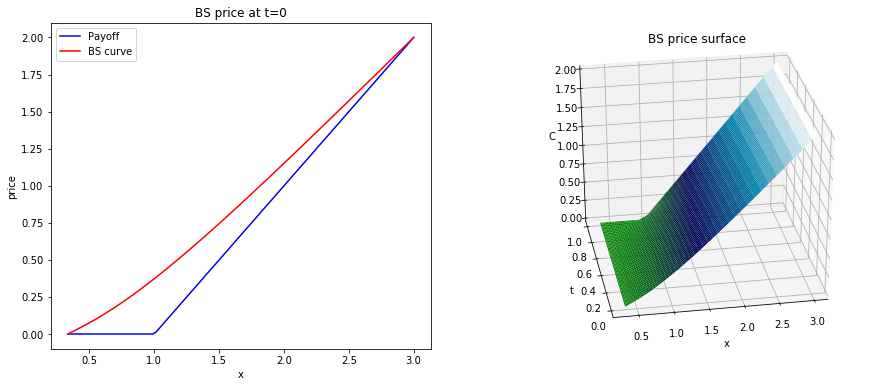

In [50]:
#We now plot the graph of the call function to see the evolution of the call function.
x = np.exp(xl)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(x, Payoff, color='blue',label="Payoff")
ax1.plot(x, Cinitial, color='red',label="BS curve")
ax1.set_xlabel("x"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T, x)
ax2.plot_surface(Y, X, C, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("x"); ax2.set_ylabel("t"); ax2.set_zlabel("C")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

<a id='sec3'></a>
## Question 2 - Explicit Euler Discretization

As for the ["Implicit discretization"](#sec2), by considering the initial BS PDE, the discretization gives us : 

$${C_{i,j}-C_{i,j-1}\over \Delta t} + ri \Delta x{C_{i+1,j}-C_{i-1,j}\over 2 \Delta x} + {1\over 2}\sigma^2(i \Delta x)^2{C_{i+1,j}-2C_{i,j}+C_{i-1,j}\over (\Delta x)^2} = rC_{i,j} $$


Here we use  backward difference approximation for t and central difference for x, expanding at  $(i\Delta x, j\Delta t))$.
After rearranging the terms in each member, we have the following result :7

$$a_i C_{i-1,j} + (1-b_i)C_{i,j} + c_i C_{i+1,j} = C_{i,j-1} $$

where :

$$a_i = {1\over 2}i\Delta t(i\sigma^2-r) $$

$$b_i = -\Delta t(i^2\sigma^2+r) $$

$$c_i = {1\over 2}i\Delta t(i\sigma^2+r) $$

So by  Substituting the formula of Neumann condition  into $C_{0,j}$ and $C_{M,j}$ , we have:


$$
 \begin{bmatrix}
  C_{1,j-1}   \\
  C_{2,j-1}   \\
  C_{3,j-1}   \\
  \vdots      \\
  C_{M-1,j-1} \\
  \end{bmatrix} =
\begin{bmatrix}
  2 a_1 + 1+b_1  & c_1 - a_1 & 0        & \cdots                      & 0           \\
  a_2             & 1+b_2             & c_2 & \cdots                      & 0           \\
  0                    & a_3            & 1+b_3  & \cdots                      & 0           \\
  \vdots               & \vdots              & \vdots   & \ddots                      & c_{M-2}\\
  0                    & 0                   & 0        & a_{M-1} - c_{M-1} & 2 c_{M-1} + 1 + b_{M-1} \\
  \end{bmatrix}
  \begin{bmatrix}
  C_{1,j}   \\
  C_{2,j}   \\
  C_{3,j}   \\
  \vdots    \\
  C_{M-1,j} \\
  \end{bmatrix} 
$$

**Numerical solution**<br/>

for the test of the function we also take in the first time $k=1$, maturity $T=1$ , volatility $\sigma = 1$, drift $ r = 0$.
the start price  $x_0 = 0.5$ price.  We choose to take $xmax = 3$.

the discritize step is  $\epsilon_{t} = \epsilon_{x} = 0.01$
 

In [173]:
def call_explicit_euler(x0 ,xmax, drift, sigma,k,T,M,N):
    
    #initialisation of local variable
    r = drift; sig = sigma              
    x0 = x0         
    K =k ; Texpir = T
    
    #================================
    Nspace = M   # M space steps
    Ntime = N  # N time steps
    
    x_max = xmax #maximun spot value of the underlying
    
    #discretization and payoff computing and grid initialization
    dx = (x_max) / float(Nspace)
    dt = Texpir / float(Ntime)
    iValues = np.arange(1,Nspace)
    jValues = np.arange(Ntime)
    C = np.zeros(shape=(Nspace+1, Ntime+1)) # grid is M+1 by N+1
    xValues = np.linspace(0, x_max, Nspace+1)
    
    
    #construction of the coefficients matrix (Diagonal matrix D) 
    a = 0.5*dt * (sig**2 * iValues**2 - r * iValues)
    b  = - dt * (sig**2 * iValues**2 + r)
    c = 0.5*dt * (sig**2 * iValues**2 + r * iValues)
    
    D = np.diag(a[1:], -1) + np.diag(1 + b) + np.diag(c[:-1], 1)
    
    #boundary condition
    # terminal condition 
    C[:, -1] = np.maximum(xValues-K,0) 
    # side boundary conditions
    D[0,   0] += 2*a[0] 
    D[0,   1] -= a[0] 
    D[-1, -1] += 2*c[-1]
    D[-1, -2] -= c[-1] 
        
    #iteration backward
    for j in reversed(jValues):
        C[1:-1, j] = np.dot(D, C[1:-1, j+1])
        C[0, j] = 2 *C[1, j] - C[2, j]
        C[-1, j] = 2 *C[-2, j] - C[-3, j]
    
    # finds the option at x0
    oPrice = np.interp(x0, xValues, C[:,0])
    
    print(oPrice)    
    #return value 
    return xValues,C[:, -1],C[:,0],C,oPrice


In [57]:
xValues,Payoff,Cinitial,C,oPrice = call_explicit_euler(0.5,3, 0,1,1,1,100,100)

#====Comment====#
#This price is very high and does not reflect the reality

3.715284252894489e+131


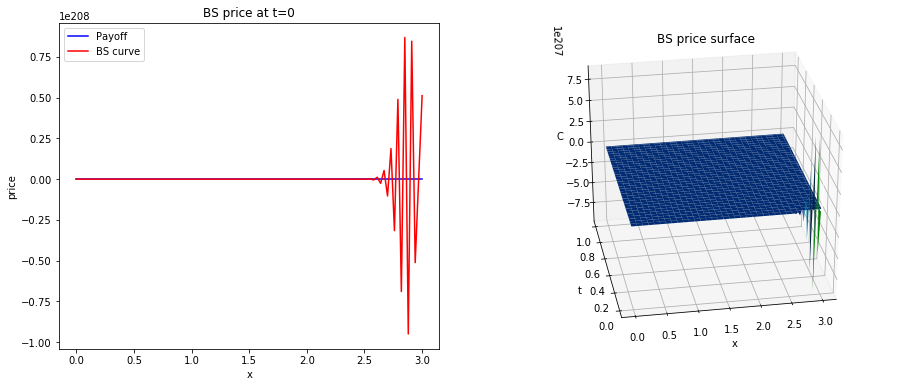

In [58]:
#We now plot the graph of the call function to see the evolution of the call function.
T =np.linspace(0, 1, 100+1)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(xValues, Payoff, color='blue',label="Payoff")
ax1.plot(xValues, Cinitial, color='red',label="BS curve")
ax1.set_xlabel("x"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(T, xValues)
ax2.plot_surface(Y, X, C, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("x"); ax2.set_ylabel("t"); ax2.set_zlabel("C")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

Here we have an oscillation of option prices. This Show the non-stability of the Explicit method, we to change the step of discretisation an make the initial condition not to small.  

In [65]:
xValuesj,Payoffj,Cinitialj,Cj,oPricej = call_explicit_euler(50,100, 0.1,0.4,55,5/12,100,1000)


4.0099800915227135


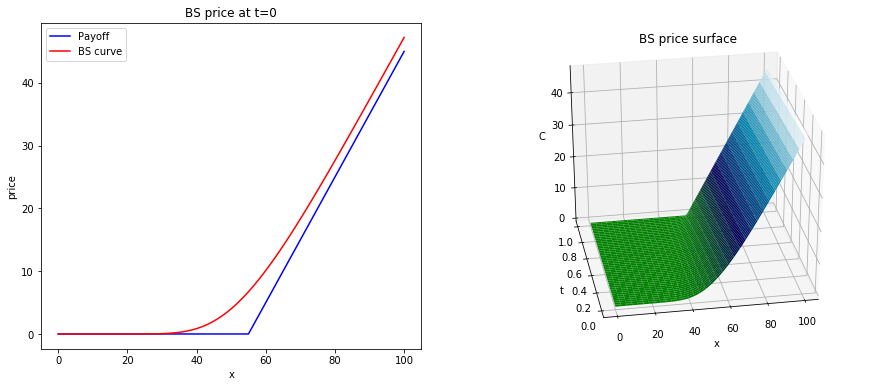

In [66]:
#We now plot the graph of the call function to see the evolution of the call function.
#x = np.exp(xl)
Tj =np.linspace(0, 1, 1000+1)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(xValuesj, Payoffj, color='blue',label="Payoff")
ax1.plot(xValuesj, Cinitialj, color='red',label="BS curve")
ax1.set_xlabel("x"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(Tj, xValuesj)
ax2.plot_surface(Y, X, Cj, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("x"); ax2.set_ylabel("t"); ax2.set_zlabel("C")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

we obtain here a more stable solution

<a id='sec4'></a>
## Question 3 -  Crank-Nicolson  Discretization

Using central difference on both t and x, we discretize B-S equation at $(i\Delta x,(j+ \frac{1}{2})\Delta t)$. Specifically, we use the average of first derivative on $(i\Delta x,(j+1)\Delta t)$ and $(i\Delta x,j\Delta t)$ to approximate the the first derivative on $(i \Delta x,(j+ \frac{1}{2})\Delta t)$. The second derivative is obtained in the same way.  We get:


$$- a_i C_{i-1,j} + (1-b_i)C_{i,j} - c_i C_{i+1,j} = a_i C_{i-1,j+1} + (1+b_i)C_{i,j+1} + c_i f_{i+1,j+1} $$

where 
$$a_i = {1\over 4}i\Delta t(i\sigma^2-r) $$

$$b_i = -{1\over 2}\Delta t(i^2\sigma^2+r) $$

$$c_i = {1\over 4}i\Delta t(i\sigma^2+r) $$

The matrix form is given by ( using neuman boundary condition) :

$$
\begin{bmatrix}
  -2a_1 + 1-b_1  & -c_1 + a_1 & 0        & \cdots                      & 0           \\
  -a_2             & 1-b_2             & -c_2 & \cdots                      & 0           \\
  0                    & -a_3            & 1-b_3  & \cdots                      & 0           \\
  \vdots               & \vdots              & \vdots   & \ddots                      & -c_{M-2}\\
  0                    & 0                   & 0        & -a_{M-1}+c_{M-1} & -2c_{M-1}+1- b_{M-1} \\
  \end{bmatrix}
  \begin{bmatrix}
  C_{1,j}   \\
  C_{2,j}   \\
  C_{3,j}   \\
  \vdots    \\
  C_{M-1,j} \\
  \end{bmatrix} = \\
  \begin{bmatrix}
  2 a_1 + 1+ b_1  & c_1 - a_1 & 0        & \cdots                      & 0           \\
  a_2             & 1+b_2             & c_2 & \cdots                      & 0           \\
  0                    & a_3            & 1+b_3  & \cdots                      & 0           \\
  \vdots               & \vdots              & \vdots   & \ddots                      & c_{M-2}\\
  0                    & 0                   & 0        & a_{M-1} - c_{M-1} & 2c_{M-1} + 1 + b_{M-1} \\
  \end{bmatrix}
  \begin{bmatrix}
  C_{1,j+1}   \\
  C_{2,j+1}   \\
  C_{3,j+1}   \\
  \vdots      \\
  C_{M-1,j+1} \\
  \end{bmatrix}
$$

Source [3]

In [182]:
def call_cranknicolson(x0 ,xmax, drift, sigma,k,T,M,N):
    
    #initialisation of local variable
    r = drift; sig = sigma              
    x0 = x0         
    K =k ; Texpir = T
    
    #================================
    Nspace = M   # M space steps
    Ntime = N  # N time steps
    
    x_max = xmax #maximun spot value of the underlying
    
    #discretization and payoff computing and grid initialization
    dx = (x_max) / float(Nspace)
    dt = Texpir / float(Ntime)
    iValues = np.arange(1,Nspace)
    jValues = np.arange(Ntime)
    C = np.zeros(shape=(Nspace+1, Ntime+1)) # grid is M+1 by N+1
    xValues = np.linspace(0, x_max, Nspace+1)
    
    
    #construction of the coefficients matrix (Diagonal matrix D1 and D2) 
    a = 0.25*dt * (sig**2 * iValues**2 - r * iValues)
    b  = -0.5*dt * (sig**2 * iValues**2 + r)
    c = 0.25*dt * (sig**2 * iValues**2 + r * iValues)
    
    
    Done = np.diag(a[1:], -1) + np.diag(1 + b) + np.diag(c[:-1], 1)
    Dtwo = np.diag(-a[1:], -1) + np.diag(1 - b) + np.diag(-c[:-1], 1)
    
    #boundary condition
    # terminal condition 
    C[:, -1] = np.maximum(xValues-K,0) 
    # side boundary conditions
    Dtwo[0,   0] -= 2*a[0] 
    Dtwo[0,   1] += a[0] 
    Dtwo[-1, -1] -= 2*c[-1]
    Dtwo[-1, -2] += c[-1] 
        
        
    #decomposition of the matrix Dtwo see scipy.linalg.lu for help     
    P,L,U = linalg.lu(Dtwo)
    
    #iteration and linear system resolution
    for j in reversed(jValues):
        Ux = linalg.solve(L, np.dot(Done, C[1:-1, j+1]))
        C[1:-1, j] = linalg.solve(U, Ux)
        C[0, j] = 2 *C[1, j] - C[2, j]
        C[-1, j] = 2 *C[-2, j] - C[-3, j]
    
    # finds the option at x0
    oPrice = np.interp(x0, xValues, C[:,0])
    
    print(oPrice)    
    #return value 
    return xValues,C[:, -1],C[:,0],C,oPrice

In [100]:
xValuesjo,Payoffjo,Cinitialjo,Cjo,oPricejo = call_cranknicolson(50,100, 0,0.4,55,5/12,100,1000)
#call_cranknicolson(50,100, 0.1,0.4,55,5/12,100,1000)
#==Comment==# 
# the ouput value seem coherent, but the scheme is not stable when we try to play with  many initial values

3.022115918386857


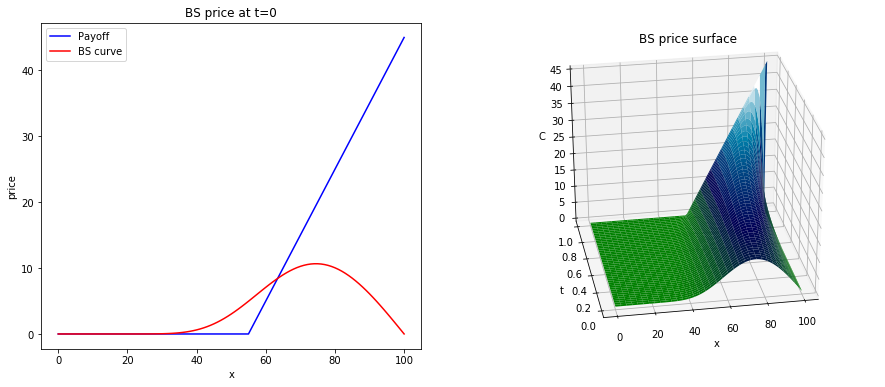

In [101]:
#We now plot the graph of the call function to see the evolution of the call function.
#x = np.exp(xl)
Tjo =np.linspace(0, 1, 1000+1)
fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

ax1.plot(xValuesjo, Payoffjo, color='blue',label="Payoff")
ax1.plot(xValuesjo, Cinitialjo, color='red',label="BS curve")
ax1.set_xlabel("x"); ax1.set_ylabel("price")
ax1.legend(loc='upper left'); ax1.set_title("BS price at t=0")

X, Y = np.meshgrid(Tjo, xValuesjo)
ax2.plot_surface(Y, X, Cjo, cmap=cm.ocean)
ax2.set_title("BS price surface")
ax2.set_xlabel("x"); ax2.set_ylabel("t"); ax2.set_zlabel("C")
ax2.view_init(30, -100) # this function rotates the 3d plot
plt.show()

<a id='sec5'></a>
## Question 4-  Comparison of  result give by numerical approach and the result give by the the BS formula

Here we take $\sigma \in [0.01,0.05,0.1,0.25,0.5,0.75,1]$

Firstly we we implemented the call price using the black and sholes formula 

In [103]:
#definition of the call price using black and sholes formula 
from scipy.stats import norm
def call_BSprice(x0, K, r, T, sig):
        d1 = ((r + 0.5 * sig**2) * T - np.log(K / x0)) / (sig * np.sqrt(T))
        d2 = ((r - 0.5 * sig**2) * T - np.log(K / x0)) / (sig * np.sqrt(T))
        
        callprice = x0 * norm.cdf(d1) - np.exp(-r * T) * K * norm.cdf(d2) 
        
        return callprice

We take as test value the following value : 

$K = 1$
$x0 = 1$
$r = 0$
$T = 1$

$\epsilon_t = \epsilon_x = 0.01$ and we change the value of $\sigma$


In [125]:
#price using black and scholes formula 
p = call_BSprice(1,1,0,1,0.25)
print(p)
#price using euler implicit
xl,Payoff,Cinitial,C,T,price1=call_implicit_euler(1, 0, 0.25)
#price using euler explicit 
xValues,Payoff,Cinitial,C,price2 = call_explicit_euler(1,10, 0,0.25,1,1,100,100)

#price using crank nicolson
xValuesjo,Payoffjo,Cinitialjo,Cjo,price3 = call_cranknicolson(1,10, 0,0.25,1,1,100,100)

0.09947644966022584
0.09947815374621456
0.09760109806575851
0.09746679743811132


| $\sigma$ Values | 0.01 | 0.05 | 0.1 | 0.25 | 0.5 |0.75 | 1 |
| --- | --- | --- |--- | --- | --- |--- | --- | 
| Black and Scholes formula | 0.033| 0.019 | 0.039 |0.09947|0.1974 |0.2923 |0.3829 |
| Euler implicit | 0.0066 | 0.0204 | 0.040 |0.09947 |0.1972 |0.2912 |0.3732 |
| Euler Explicit | 0.00049 | 0.011 | 0.0337 |0.09760 |-5.36e+54 |2.40e+91 |1.03e+117 |
| Crank Nicolson | 0.00049 | 0.011 | 0.0336 |0.09746 |1.65e+46 |4.34e+94 |2.59e+125 |


we notice that from high $\sigma$ ($\sigma>0.25$) the explicit  and Crank shemes don't  give more consistent values. We have a bifurcation of values

<a id='sec6'></a>
## Question 5-  $\epsilon_{t}$ and $\epsilon_{x}$ for better convergence 



In [147]:
#price using black and scholes formula 
p = call_BSprice(1,1,0,1,0.25)
print(p)
#price using euler implicit
xl,Payoff,Cinitial,C,T,price1=call_implicit_euler(1, 0, 0.25)
#price using euler explicit 
xValues,Payoff,Cinitial,C,price2 = call_explicit_euler(1,10, 0,0.25,1,1,100,10)

#price using crank nicolson
xValuesjo,Payoffjo,Cinitialjo,Cjo,price3 = call_cranknicolson(1,10, 0,0.25,1,1,100,1000)

0.09947644966022584
0.09947815374621456
0.09880185332743865
0.09746644742889576


By varying the values of the steps $\epsilon_t$ and $\epsilon_t$ , we notice that: the greater the step in time $\epsilon_t$, the more we have a good convergence of the explicit Euler scheme. on the other hand for the Crank nicolson discretization, the smaller the step in time, the more the convergence seems to be good when the sigma parameter is varied. 

In both cases, the divergence of the algorithms is very sensitive to the variation of the step in space $\epsilon_x$. We finally set it at $0.01$. 
one obtained a better convergence of the explicit algorithm for a time step equal to $\epsilon_t = 0.1$ and for a Crank algorithm we obtained better convergence  for $\epsilon_t = 0.001$.

the explicit scheme seems  to be more consistent in value and already seems to be a better approximation of the price of the call than the other two methods.



In [185]:
#we define here a new implicit function. In fact, we want to add a new parameters when we call the function
def call_implicit_eulerspecial(x0 , drift, sigma,M,N):
    
    #initialisation of local variable
    r = drift; sig = sigma              
    x0 = x0; xl0 = np.log(x0)          
    K = 55; Texpir = 5/12 
    #================================
    Nspace = M   # M space steps
    Ntime = N   # N time steps   
    
    # we choose here to compute the spot between  xmax = 3*float(K) and xmin = float(K)/3  this is according litterature 
    x_max = 3*float(K)                   
    x_min = float(K)/3

    xl_max = np.log(x_max)  
    xl_min = np.log(x_min)  
    
    #discretization and payoff computing 
    xl, dxl = np.linspace(xl_min, xl_max, Nspace, retstep=True)   # space discretization
    T, dt = np.linspace(0, Texpir, Ntime, retstep=True)               # time discretization
    Payoff = np.maximum(np.exp(xl)-K,0)                                # Call payoff
    
    
    C = np.zeros((Nspace,Ntime))       # grid initialization
    B = np.zeros(Nspace-2)        # vector to be used for the boundary terms (B)   

    C[:,-1] = Payoff                   # terminal conditions 
    C[-1,:] = np.exp(xl_max) - K * np.exp(-r* T[::-1] )  # boundary condition
    C[0,:] = 0                         # boundary condition
    
    # construction of the tri-diagonal matrix D
    sig2 = sig*sig; dxxl = dxl * dxl

    a = ( (dt/2) * ( (r-0.5*sig2)/dxl - sig2/dxxl ) )
    b = ( 1 + dt * ( sig2/dxxl + r ) )
    c = (-(dt/2) * ( (r-0.5*sig2)/dxl + sig2/dxxl ) )

    D = sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace-2, Nspace-2)).tocsc()
    
    #iteration (reversing the time)
    for i in range(Ntime-2,-1,-1):
        B[0] = a * C[0,i]
        B[-1] = c * C[-1,i]; 
        C[1:-1,i] = spsolve( D, (C[1:-1,i+1] - B) )  
        
    # finds the option at x0
    oPrice = np.interp(xl0, xl, C[:,0])
    
    print(oPrice)
    
    return xl,Payoff,C[:,0],C,T,oPrice
    

In [198]:
# convergence implicit scheme, explicit scheme and crank nicolson
#just for this illustration and because of the stability of the different scheme, we have choose to use specific value to illustrate
#the convergence of the different scheme by varing time and space step
mspace = np.array([50, 100, 200, 400]) # given by epsilonx
ntime = np.array([100, 200, 400, 800]) #given by epsilont

p = np.array([])
pc = np.array([])
pd = np.array([])
for M, N in zip(mspace, ntime):
    xl,Payoff,Cinitial,C,T,callprice = call_implicit_eulerspecial(50, 0, 0.01,M,N)
    xValuesjo,Payoffjo,Cinitialjo,Cjo,oPricejo = call_cranknicolson(50,100, 0,0.01,55,5/12,M,N)
    xValues,Payoff,Cinitial,C,pdrice = call_explicit_euler(50,100, 0,0.01,55,1,M,N)
    p = np.append(p, callprice)
    pc = np.append(pc, oPricejo)
    pd = np.append(pd, pdrice)
analyticprice = call_BSprice(1,1,0,1,0.25)
#computing the different error
errorimplicit = np.abs(p-analyticprice)
errorexplicit = np.abs(pd-analyticprice)
errorCrankN = np.abs(pc-analyticprice)


2.408188027069745e-05
4.5635835734426777e-07
5.984213641264789e-06
1.612666144983215e-08
4.4864388549235836e-11
6.9869937109971806e-09
7.038224684409867e-14
7.676930480126661e-16
5.907966519112878e-12
5.1767530726592874e-20
1.4606617083100215e-22
1.2229911261268126e-15


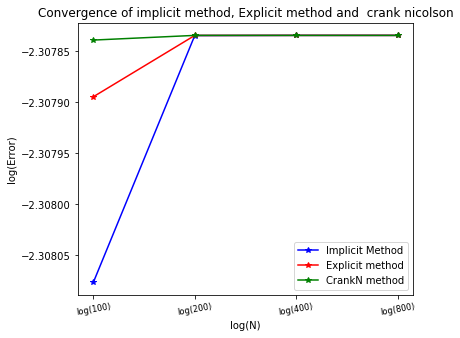

In [200]:
#plotting
fig = plt.figure(figsize=(6,5)) 
ax = fig.gca()
ax.plot(np.log(ntime), np.log(errorimplicit), '*-', c='blue')
ax.plot(np.log(ntime), np.log(errorexplicit), '*-', c='red')
ax.plot(np.log(ntime), np.log(errorCrankN), '*-', c='green')
ticks = ax.set_xticks(np.log(ntime))
labels = ax.set_xticklabels(['log(100)', 'log(200)', 
                                 'log(400)', 'log(800)'], rotation=10, fontsize='small')
ax.set_xlabel('log(N)')
ax.set_ylabel('log(Error)')
ax.set_title('Convergence of implicit method, Explicit method and  crank nicolson')
plt.legend(['Implicit Method','Explicit method', 'CrankN method'])
plt.show()



The implicit scheme  seems to converge faster than the explicit and crank nicolson  scheme (When we decrease the time step).

<a id='sec7'></a>
## Question 6-  Stability of numerical schemes. 

**Stability of a numerical scheme**
More generally, a problem is said to be stable, very sensitive or poorly conditioned if a small variation in the data or parameters results in a large variation in the results. For a digital scheme, it is the property that ensures that the difference between the numerical solution obtained and the exact solution of the discretized equations is bounded.

source : [4]

To study the stability of the schmes, we are going to see their behavior in the neighbourhood of strike $K$. Let us therefore consider $\nu$ one  neighbourhood of strike k.  we can write $ \nu $ in the following way: $ \nu = [k-\delta,k+\delta]$.

Taking $\delta = 0.5$, we can use the following values for x0 : $ 0.5, 0.55, 0.70,0.75$. we set volatility at $0.01$

In [163]:
#price using euler implicit
xl,Payoff,Cinitial,C,T,price1=call_implicit_euler(0.75, 0, 0.01)
#price using euler explicit 
xValues,Payoff,Cinitial,C,price2 = call_explicit_euler(0.75,10, 0,1,0.01,1,100,100)

#price using crank nicolson
xValuesjo,Payoffjo,Cinitialjo,Cjo,price3 = call_cranknicolson(0.75,10, 0,0.01,1,1,100,100)

1.7722776882703353e-25
-1.076806164256304e+112
5.370605004961462e-10


| $x0$ Values | 0.5 | 0.75 |1 |
| --- | --- | --- |--- |  
| Euler implicit | 2.32e-66 | 1.77e-25 | 0.0066 |
| Euler Explicit | 1.72e+104 | -1.07e+112 | -1.06e+117 |
| Crank Nicolson | 4.94e-20 | 5.37e-10 | 0.00049 |


Using the previous questions, we can deduce that the implicit Euler scheme is more stable than the Crank nicolson scheme which itself is more stable than the Euler Explicit scheme.


## Question 7-   for $r \neq 0$. 

For $r \neq 0$ (e.g $r=0.4$), one easily checks that the results on the convergence and the stability of the schemes change. Indeed the r intervenes in the coefficients of our different matrices. It therefore plays an important role in the resolution of the linear system.

## References 
[1] Didier Auroux (2011). Méthodes Numériques Pour Le Pricing D'otions.

[2] Wilmott Paul (1994). Option pricing: Mathematical models and computation. Oxford Financial Press.

[3]  On Pricing Options with Finite Difference Methods. Link, https://quintus-zhang.github.io/post/on_pricing_options_with_finite_difference_methods/#more

[4] SIDIBE Ali Broma(2019). Résolution numérique de l’équation de Black-Scholes 
